

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* https://huggingface.co/docs/transformers/training
* https://huggingface.co/docs/datasets/main/en/repository_structure
* https://huggingface.co/docs/datasets/main/en/package_reference/loading_methods
* https://huggingface.co/docs/transformers/v4.35.2/en/training
* https://huggingface.co/docs/datasets/v2.0.0/en/image_process
* https://huggingface.co/docs/datasets/v3.0.1/en/package_reference/main_classes
* https://huggingface.co/docs/datasets/process
* https://huggingface.co/docs/evaluate/index
* https://huggingface.co/docs/transformers/main_classes/trainer
* https://huggingface.co/docs/transformers/v4.35.2/en/main_classes/trainer
* https://albumentations.ai/docs/getting_started/image_augmentation/
* https://wandb.ai/ayush-thakur/huggingface/reports/Examples-of-Early-Stopping-in-HuggingFace-Transformers--Vmlldzo0MzE2MTM
* https://colab.research.google.com/github/wandb/examples/blob/master/colabs/huggingface/Optimize_Hugging_Face_models_with_Weights_&_Biases.ipynb

1\. Обсудите основные шаги по дообучению моделей из экосистемы 🤗 Transformers.

<p class="task" id="1"></p>

1\. Создайте набор данных для обучения модели классификации пород кошек, используя пакет 🤗 Datasets. Разделите датасет на обучающее и тестовое множество в соотношении 80/20. 

К обучающему множеству примените следующие преобразования из пакета `albumentations`:
- Resize до 256х256;
- CenterCrop до размера 224х224;
- минимум одно преобразование, случайным образом изменяющее изображение.

К тестовому множеству примените аналогичное преобразование, но без добавления случайных изменений.

Создайте два `DataLoader` на основе обучающего и валидационного множества. Получите батч из обучающего множества и форму признаков и меток на экран. Признаки в батче должны быть уложены в четырехмерный тензор.



- [ ] Проверено на семинаре

In [3]:
import torchvision.models as models
import torchvision.transforms.v2 as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch as th
import torchmetrics as M
import time
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from transformers import AutoModelForImageClassification, AutoFeatureExtractor, Trainer, TrainingArguments

In [2]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")

train_transform  = A.Compose([
    A.Resize(256, 256), 
    A.CenterCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
    ToTensorV2()
])

class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        image = np.array(image)
        augmented = self.transform(image=image)
        return augmented['image']

c:\Users\Danya\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\convnext\feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [3]:
dataset = ImageFolder(root='./cat_breeds_4/cat_breeds_4')
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

train_dataset.dataset.transform = AlbumentationsTransform(train_transform)
test_dataset.dataset.transform = AlbumentationsTransform(test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
images.shape

torch.Size([32, 3, 224, 224])

<p class="task" id="2"></p>

2\. Создайте модель при помощи класса `AutoModelForImageClassification`, заменив голову модели в соответствии с решаемой задачей  классификации. Используя стандартный цикл обучения `torch` (или `pytorch_lightning`), настройте модель. Во время обучения выводите на экран значение функции потерь и значение F1 на обучающем множестве, а также F1 на валидационном множестве. 

- [ ] Проверено на семинаре

In [4]:
import torchvision.models as models
import torchvision.transforms.v2 as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch as th
import torchmetrics as M
import time
import wandb
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from transformers import AutoModelForImageClassification, AutoFeatureExtractor, Trainer, TrainingArguments
from tqdm import tqdm

In [6]:
train_transform  = A.Compose([
    A.Resize(256, 256), 
    A.CenterCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        image = np.array(image)
        augmented = self.transform(image=image)
        return augmented['image']

In [7]:
dataset = ImageFolder(root='./cat_breeds_4/cat_breeds_4')
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

train_dataset.dataset.transform = AlbumentationsTransform(train_transform)
test_dataset.dataset.transform = AlbumentationsTransform(test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
model_name = "microsoft/resnet-50"
num_classes = 4 
device = th.device("cuda" if th.cuda.is_available() else "cpu")

model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes, 
    ignore_mismatched_sizes=True
).to(device)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

train_f1 = M.F1Score(task='multiclass', num_classes=num_classes, average='weighted').to(device)
val_f1 = M.F1Score(task='multiclass', num_classes=num_classes, average='weighted').to(device)


def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    train_f1.reset()
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = th.argmax(outputs, dim=1)
        train_f1.update(preds, labels)

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    f1_score = train_f1.compute()
    return avg_loss, f1_score

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    val_f1.reset()
    with th.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)

            preds = th.argmax(outputs, dim=1)
            val_f1.update(preds, labels)

            running_loss += loss.item()

    avg_loss = running_loss / len(val_loader)
    f1_score = val_f1.compute()
    return avg_loss, f1_score

In [10]:
for epoch in range(5):
    print(f"Epoch {epoch + 1}/{5}")

    train_loss, train_f1_score = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}, Training F1: {train_f1_score:.4f}")

    val_loss, val_f1_score = evaluate(model, test_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Validation F1: {val_f1_score:.4f}")

Epoch 1/5


Training Loss: 1.3268, Training F1: 0.5014


Validation Loss: 1.2424, Validation F1: 0.6867
Epoch 2/5


Training Loss: 1.0875, Training F1: 0.7177


Validation Loss: 0.8918, Validation F1: 0.7258
Epoch 3/5


Training Loss: 0.7444, Training F1: 0.7728


Validation Loss: 0.6347, Validation F1: 0.7708
Epoch 4/5


Training Loss: 0.5413, Training F1: 0.8224


Validation Loss: 0.5129, Validation F1: 0.8029
Epoch 5/5


Training Loss: 0.4352, Training F1: 0.8428


Validation Loss: 0.4547, Validation F1: 0.8209


<p class="task" id="3"></p>

3\. Создайте модель при помощи класса `AutoModelForImageClassification`, заменив голову модели в соответствии решаемой задачей  классификации. Используя `transformers.Trainer`, настройте модель для решения задачи. Во время обучения выводите на экран значение функции потерь на обучающем и валидационном множества, а также F1 на валидационном множестве. 

Настройте `Trainer` таким образом, чтобы логирование процесса обучения осуществлялось при помощи `wandb`. Прикрепите скриншоты интерфейса `wandb` с результатами. 

- [ ] Проверено на семинаре


In [85]:
from transformers import TrainingArguments, Trainer
import wandb
from torch.utils.data import Dataset
import evaluate
from transformers import AutoImageProcessor

In [86]:
train_transform  = A.Compose([
    A.Resize(256, 256), 
    A.CenterCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    ToTensorV2()
])

class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        image = np.array(image)
        augmented = self.transform(image=image)
        return augmented['image']
    

dataset = ImageFolder(root='./cat_breeds_4/cat_breeds_4')
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

train_dataset.dataset.transform = AlbumentationsTransform(train_transform)
test_dataset.dataset.transform = AlbumentationsTransform(test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [87]:
wandb.init(project="cat_breeds_classification", name="resnet50_trainer")

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
class ImageClassificationDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        encoding = self.processor(image, return_tensors='pt')
        pixel_values = encoding['pixel_values'].squeeze()
        return {'pixel_values': pixel_values, 'labels': label}

train_dataset = ImageClassificationDataset(train_dataset, processor)
eval_dataset = ImageClassificationDataset(test_dataset, processor)

train/epoch,▁
train/global_step,▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
train/epoch,1
train/global_step,100
train/grad_norm,2.15977
train/learning_rate,5e-05
train/loss,1.3505


In [88]:
num_labels = len(dataset.classes)
label_names = dataset.classes
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}

model = AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [89]:
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)['accuracy']
    f1 = f1_metric.compute(predictions=preds, references=labels, average='weighted')['f1']
    return {'accuracy': accuracy, 'f1': f1}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    save_strategy='epoch',
    eval_strategy='epoch',
    logging_strategy='steps',
    logging_steps=100,
    metric_for_best_model='f1',
    report_to='wandb',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [15]:
trainer.train()

wandb.finish()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 1.3326, 'grad_norm': 2.50333833694458, 'learning_rate': 4e-05, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.2718327045440674, 'eval_accuracy': 0.66125, 'eval_f1': 0.6136293202867925, 'eval_runtime': 3.4555, 'eval_samples_per_second': 231.514, 'eval_steps_per_second': 7.235, 'epoch': 1.0}
{'loss': 1.1847, 'grad_norm': 2.0477445125579834, 'learning_rate': 3e-05, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.0956436395645142, 'eval_accuracy': 0.715, 'eval_f1': 0.6846162793183018, 'eval_runtime': 3.3387, 'eval_samples_per_second': 239.611, 'eval_steps_per_second': 7.488, 'epoch': 2.0}
{'loss': 0.9937, 'grad_norm': 2.622553586959839, 'learning_rate': 2e-05, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.9264160394668579, 'eval_accuracy': 0.73125, 'eval_f1': 0.7046079233612045, 'eval_runtime': 3.4911, 'eval_samples_per_second': 229.152, 'eval_steps_per_second': 7.161, 'epoch': 3.0}
{'loss': 0.8519, 'grad_norm': 2.4117002487182617, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.8290045261383057, 'eval_accuracy': 0.75375, 'eval_f1': 0.7311986244209262, 'eval_runtime': 3.3219, 'eval_samples_per_second': 240.825, 'eval_steps_per_second': 7.526, 'epoch': 4.0}
{'loss': 0.7862, 'grad_norm': 4.772650718688965, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.8167240023612976, 'eval_accuracy': 0.76125, 'eval_f1': 0.7422338508377895, 'eval_runtime': 3.3513, 'eval_samples_per_second': 238.71, 'eval_steps_per_second': 7.46, 'epoch': 5.0}
{'train_runtime': 108.7154, 'train_samples_per_second': 147.173, 'train_steps_per_second': 4.599, 'train_loss': 1.0298124389648438, 'epoch': 5.0}


eval/accuracy,▁▅▆▇█
eval/f1,▁▅▆▇█
eval/loss,█▅▃▁▁
eval/runtime,▇▂█▁▂
eval/samples_per_second,▂▇▁█▇
eval/steps_per_second,▂▇▁█▇
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▅▅▆▆███
train/grad_norm,▂▁▂▂█
train/learning_rate,█▆▅▃▁
train/loss,█▆▄▂▁


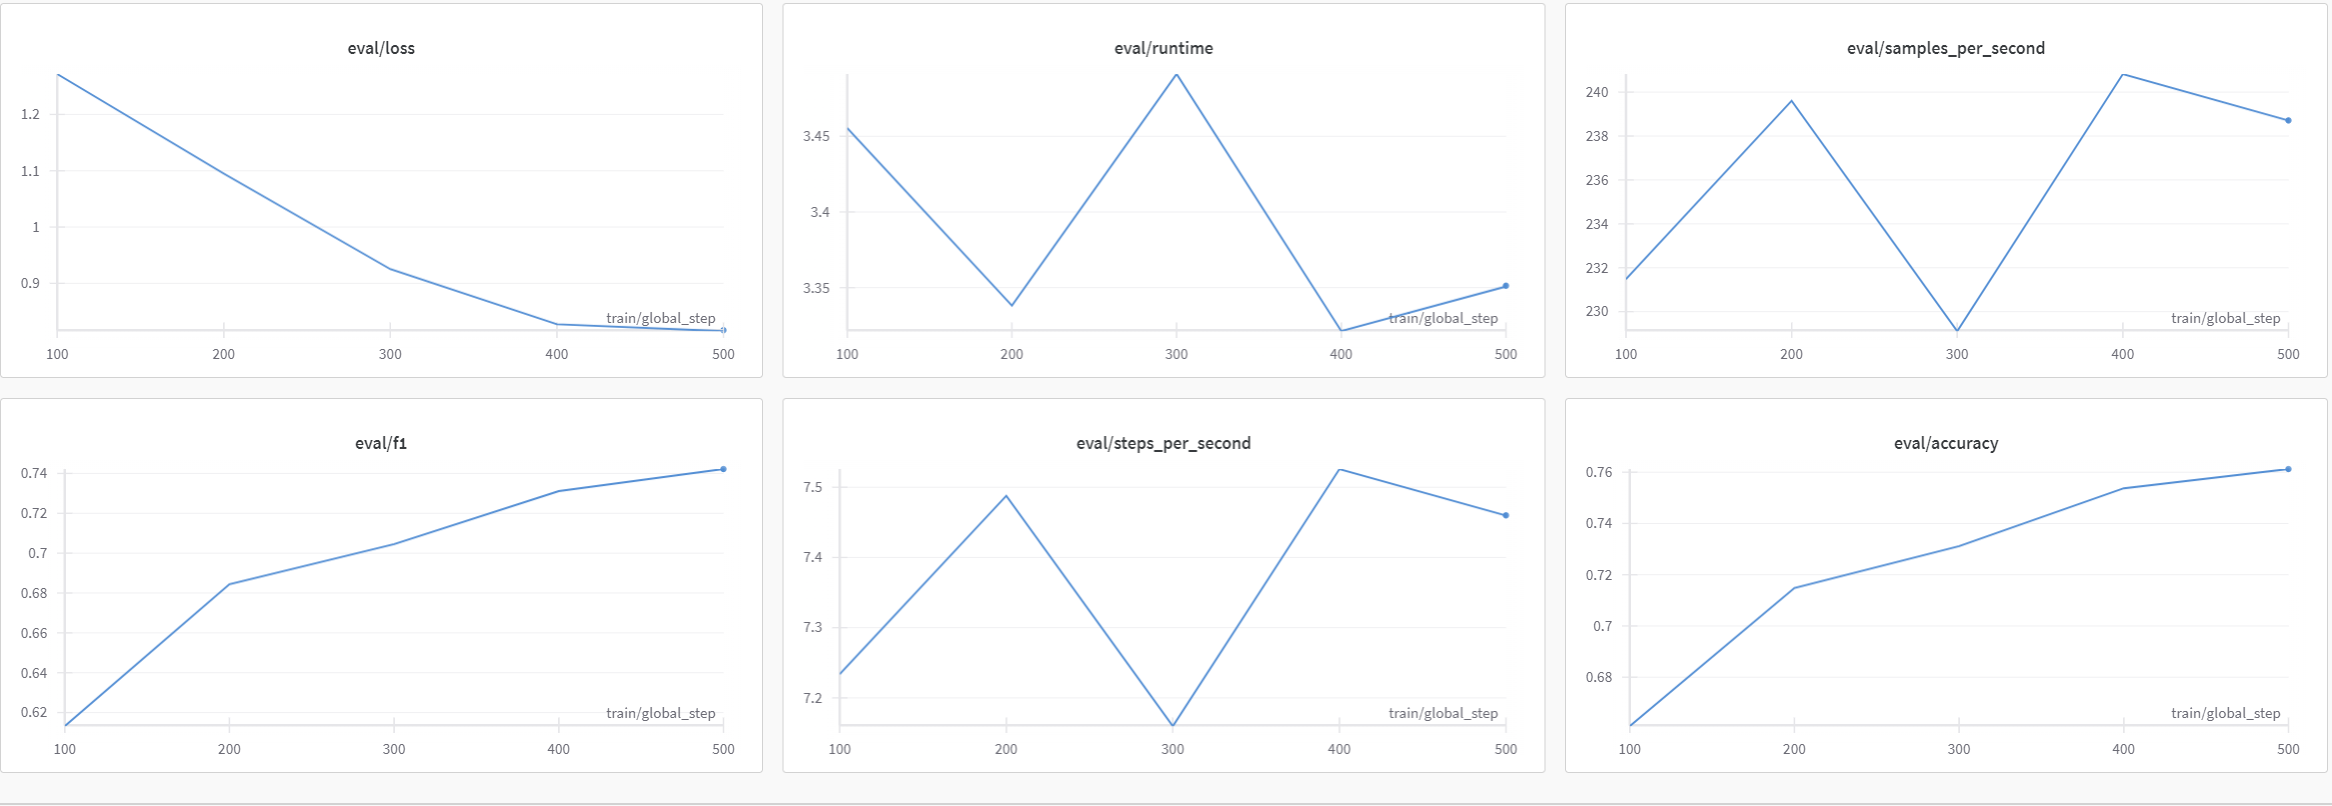

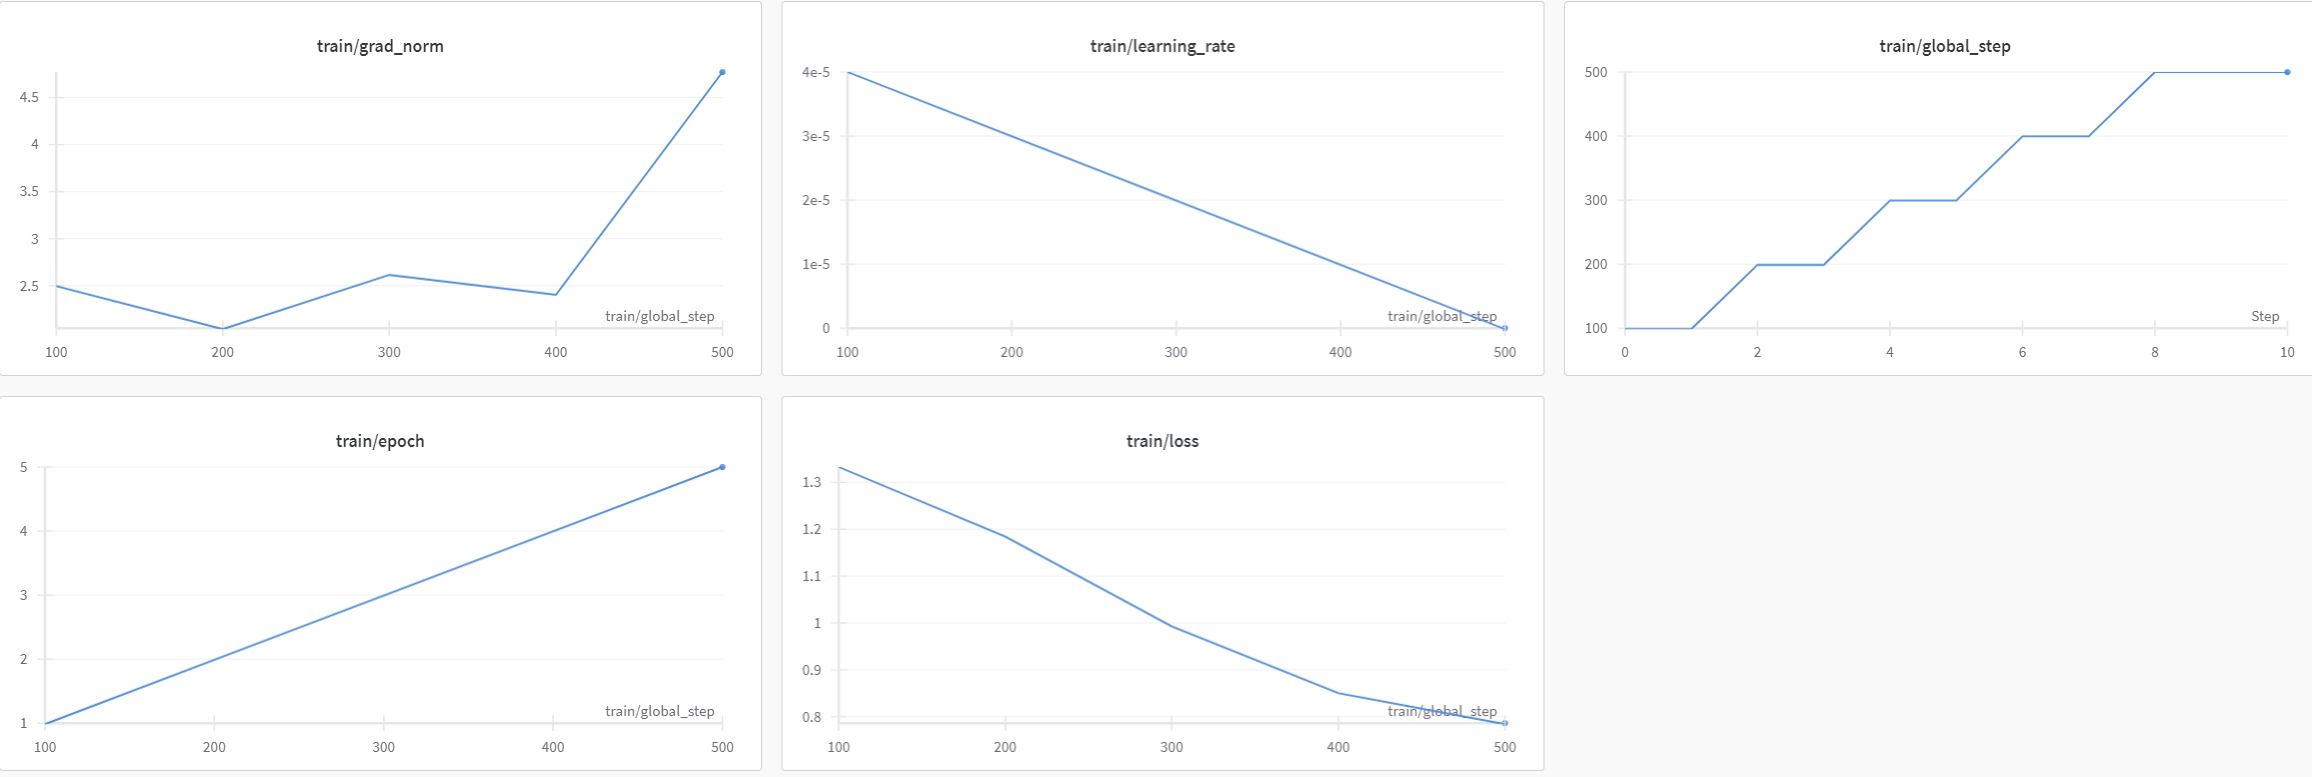

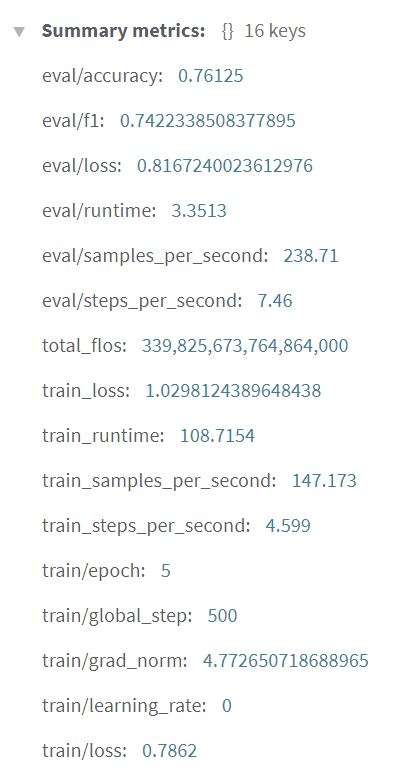

<p class="task" id="4"></p>

4\. Повторите решение задачи 3, настроив процедуру ранней остановки (используйте механизм callback для Trainer). Логика ранней остановки следующая: если метрика F1 не увеличивалась на валидационном множестве в течение 3 последних эпох, то процесс обучения останавливается.

- [ ] Проверено на семинаре


In [10]:
from transformers import EarlyStoppingCallback, TrainingArguments, Trainer, AutoImageProcessor, AutoModelForImageClassification
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import evaluate
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb
from tqdm import tqdm


wandb.init(project="cat_breeds_classification", name="resnet50_trainer_early_stopping")

train_transform = A.Compose([
    A.Resize(256, 256), 
    A.CenterCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
])


class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        image = np.array(image)
        augmented = self.transform(image=image)
        return augmented['image']


dataset = ImageFolder(root='./cat_breeds_4/cat_breeds_4')
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_subset, test_subset = random_split(dataset, [train_size, test_size])


train_subset.dataset.transform = AlbumentationsTransform(train_transform)
test_subset.dataset.transform = AlbumentationsTransform(test_transform)


In [11]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")


class ImageClassificationDataset(Dataset):
    def __init__(self, subset, processor):
        self.subset = subset
        self.processor = processor

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        
        
        encoding = self.processor(images=image, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        
        return {"pixel_values": pixel_values, "labels": torch.tensor(label, dtype=torch.long)}


train_dataset = ImageClassificationDataset(train_subset, processor)
eval_dataset = ImageClassificationDataset(test_subset, processor)

In [12]:
num_labels = len(dataset.classes)
label_names = dataset.classes
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}


model = AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)


accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")


def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": accuracy, "f1": f1}


early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
)


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=30,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    save_strategy='epoch',
    eval_strategy='epoch',
    logging_strategy='steps',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    report_to='wandb',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)


trainer.train()


wandb.finish()


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([4, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3000 [00:00<?, ?it/s]

{'loss': 1.3379, 'grad_norm': 2.185825824737549, 'learning_rate': 4.8333333333333334e-05, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.2773849964141846, 'eval_accuracy': 0.66375, 'eval_f1': 0.6360287801291153, 'eval_runtime': 3.3833, 'eval_samples_per_second': 236.454, 'eval_steps_per_second': 7.389, 'epoch': 1.0}
{'loss': 1.163, 'grad_norm': 3.5751254558563232, 'learning_rate': 4.666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.042361855506897, 'eval_accuracy': 0.73125, 'eval_f1': 0.6896890686001116, 'eval_runtime': 3.6775, 'eval_samples_per_second': 217.536, 'eval_steps_per_second': 6.798, 'epoch': 2.0}
{'loss': 0.8878, 'grad_norm': 2.64638090133667, 'learning_rate': 4.5e-05, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.7878041863441467, 'eval_accuracy': 0.7675, 'eval_f1': 0.7428645469446102, 'eval_runtime': 3.2962, 'eval_samples_per_second': 242.7, 'eval_steps_per_second': 7.584, 'epoch': 3.0}
{'loss': 0.669, 'grad_norm': 2.576019525527954, 'learning_rate': 4.3333333333333334e-05, 'epoch': 4.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.6454795598983765, 'eval_accuracy': 0.7775, 'eval_f1': 0.7595715748964179, 'eval_runtime': 3.2628, 'eval_samples_per_second': 245.189, 'eval_steps_per_second': 7.662, 'epoch': 4.0}
{'loss': 0.5399, 'grad_norm': 2.076589345932007, 'learning_rate': 4.166666666666667e-05, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.5640364289283752, 'eval_accuracy': 0.79125, 'eval_f1': 0.7804445386376156, 'eval_runtime': 3.2898, 'eval_samples_per_second': 243.173, 'eval_steps_per_second': 7.599, 'epoch': 5.0}
{'loss': 0.4631, 'grad_norm': 2.3253703117370605, 'learning_rate': 4e-05, 'epoch': 6.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.5285148620605469, 'eval_accuracy': 0.80625, 'eval_f1': 0.801471163709103, 'eval_runtime': 3.2216, 'eval_samples_per_second': 248.323, 'eval_steps_per_second': 7.76, 'epoch': 6.0}
{'loss': 0.3906, 'grad_norm': 3.6319801807403564, 'learning_rate': 3.8333333333333334e-05, 'epoch': 7.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.4990381598472595, 'eval_accuracy': 0.8125, 'eval_f1': 0.8094804078167873, 'eval_runtime': 3.257, 'eval_samples_per_second': 245.625, 'eval_steps_per_second': 7.676, 'epoch': 7.0}
{'loss': 0.349, 'grad_norm': 2.386676073074341, 'learning_rate': 3.6666666666666666e-05, 'epoch': 8.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.4928711950778961, 'eval_accuracy': 0.81625, 'eval_f1': 0.8119284886674414, 'eval_runtime': 3.2351, 'eval_samples_per_second': 247.284, 'eval_steps_per_second': 7.728, 'epoch': 8.0}
{'loss': 0.3002, 'grad_norm': 2.2658774852752686, 'learning_rate': 3.5e-05, 'epoch': 9.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.48479992151260376, 'eval_accuracy': 0.81875, 'eval_f1': 0.8167486733285904, 'eval_runtime': 3.2413, 'eval_samples_per_second': 246.815, 'eval_steps_per_second': 7.713, 'epoch': 9.0}
{'loss': 0.2628, 'grad_norm': 3.274315357208252, 'learning_rate': 3.3333333333333335e-05, 'epoch': 10.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.5004673004150391, 'eval_accuracy': 0.81625, 'eval_f1': 0.8127371729908758, 'eval_runtime': 3.3083, 'eval_samples_per_second': 241.818, 'eval_steps_per_second': 7.557, 'epoch': 10.0}
{'loss': 0.2264, 'grad_norm': 4.391988754272461, 'learning_rate': 3.1666666666666666e-05, 'epoch': 11.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.5087578892707825, 'eval_accuracy': 0.8175, 'eval_f1': 0.8150671954625386, 'eval_runtime': 3.2638, 'eval_samples_per_second': 245.117, 'eval_steps_per_second': 7.66, 'epoch': 11.0}
{'loss': 0.2065, 'grad_norm': 2.409980058670044, 'learning_rate': 3e-05, 'epoch': 12.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.5206786394119263, 'eval_accuracy': 0.82125, 'eval_f1': 0.8200504504803408, 'eval_runtime': 3.2742, 'eval_samples_per_second': 244.337, 'eval_steps_per_second': 7.636, 'epoch': 12.0}
{'loss': 0.1762, 'grad_norm': 1.5715243816375732, 'learning_rate': 2.8333333333333335e-05, 'epoch': 13.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.5385684370994568, 'eval_accuracy': 0.815, 'eval_f1': 0.8139734344283623, 'eval_runtime': 3.2058, 'eval_samples_per_second': 249.55, 'eval_steps_per_second': 7.798, 'epoch': 13.0}
{'loss': 0.1546, 'grad_norm': 2.280334949493408, 'learning_rate': 2.6666666666666667e-05, 'epoch': 14.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.5387746095657349, 'eval_accuracy': 0.815, 'eval_f1': 0.8132635540598743, 'eval_runtime': 3.2716, 'eval_samples_per_second': 244.531, 'eval_steps_per_second': 7.642, 'epoch': 14.0}
{'loss': 0.1331, 'grad_norm': 2.650026798248291, 'learning_rate': 2.5e-05, 'epoch': 15.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.5740561485290527, 'eval_accuracy': 0.8175, 'eval_f1': 0.8155108739037535, 'eval_runtime': 3.2382, 'eval_samples_per_second': 247.047, 'eval_steps_per_second': 7.72, 'epoch': 15.0}
{'train_runtime': 313.4321, 'train_samples_per_second': 306.286, 'train_steps_per_second': 9.571, 'train_loss': 0.483999272664388, 'epoch': 15.0}


eval/accuracy,▁▄▆▆▇▇█████████
eval/f1,▁▃▅▆▆▇█████████
eval/loss,█▆▄▂▂▁▁▁▁▁▁▁▁▁▂
eval/runtime,▄█▂▂▂▁▂▁▂▃▂▂▁▂▁
eval/samples_per_second,▅▁▇▇▇█▇█▇▆▇▇█▇▇
eval/steps_per_second,▅▁▇▇▇█▇█▇▆▇▇█▇▇
train/epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇███
train/grad_norm,▃▆▄▃▂▃▆▃▃▅█▃▁▃▄
train/learning_rate,█▇▇▆▆▅▅▅▄▄▃▂▂▂▁
train/loss,█▇▅▄▃▃▂▂▂▂▂▁▁▁▁


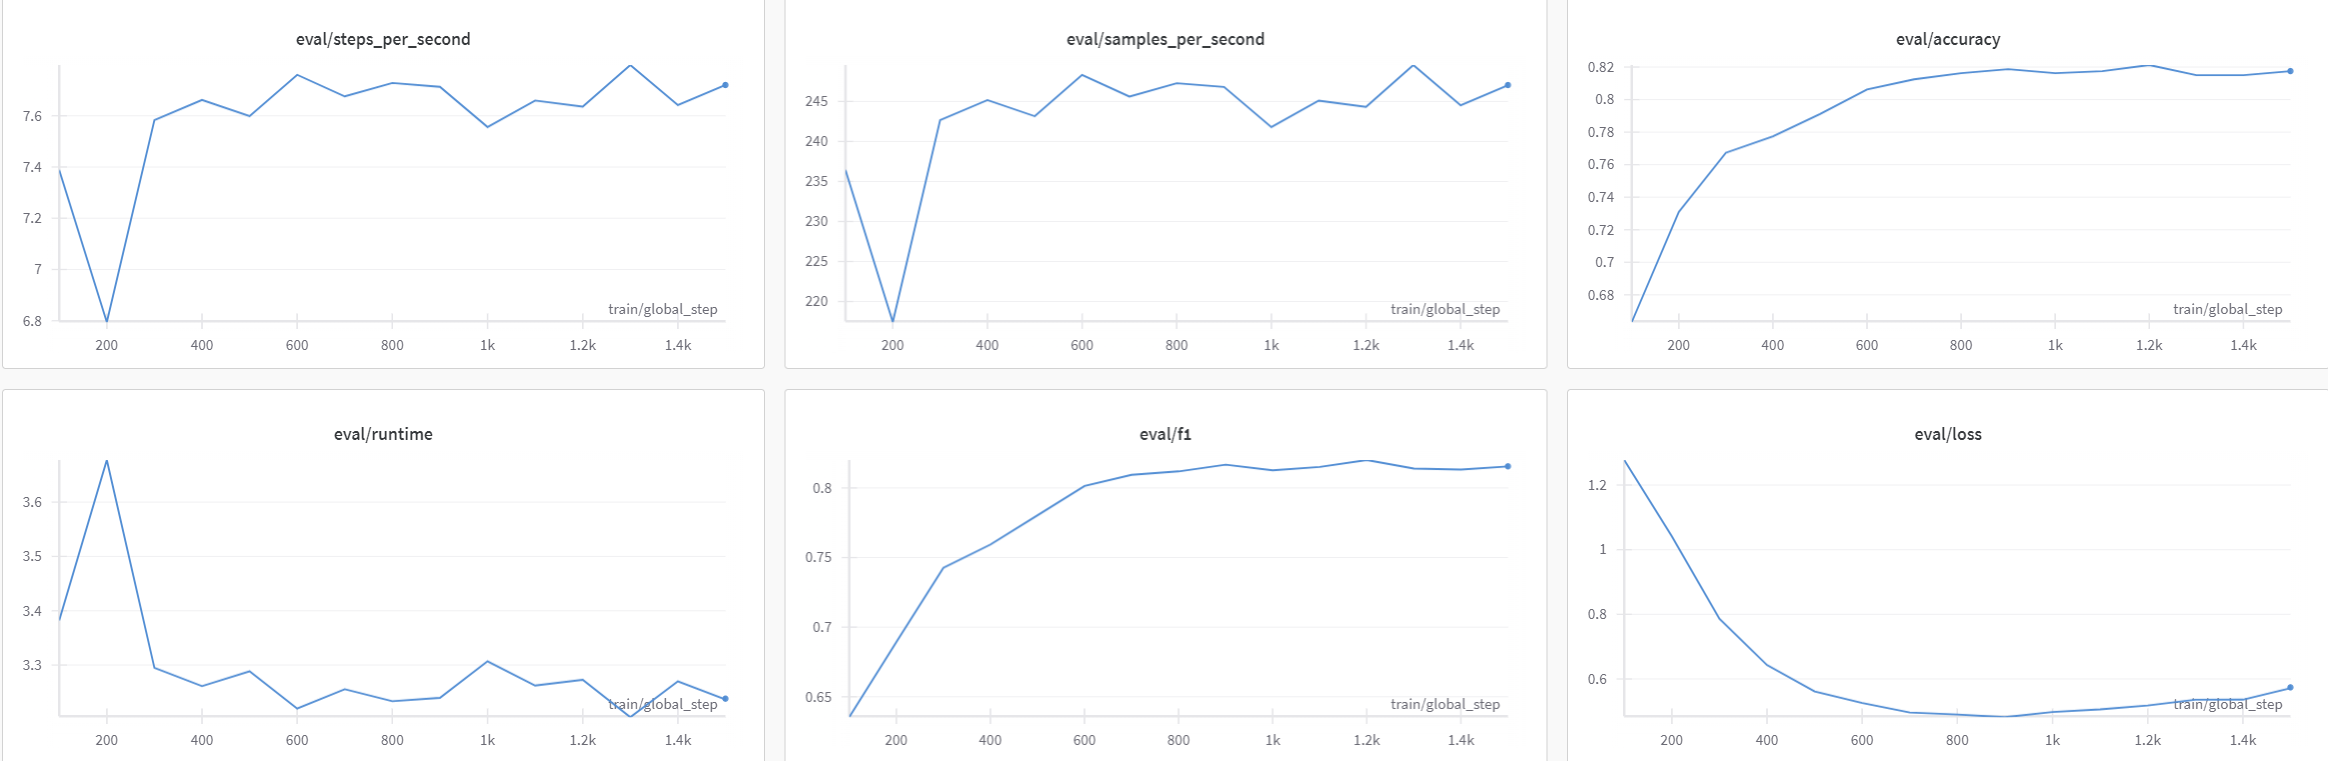

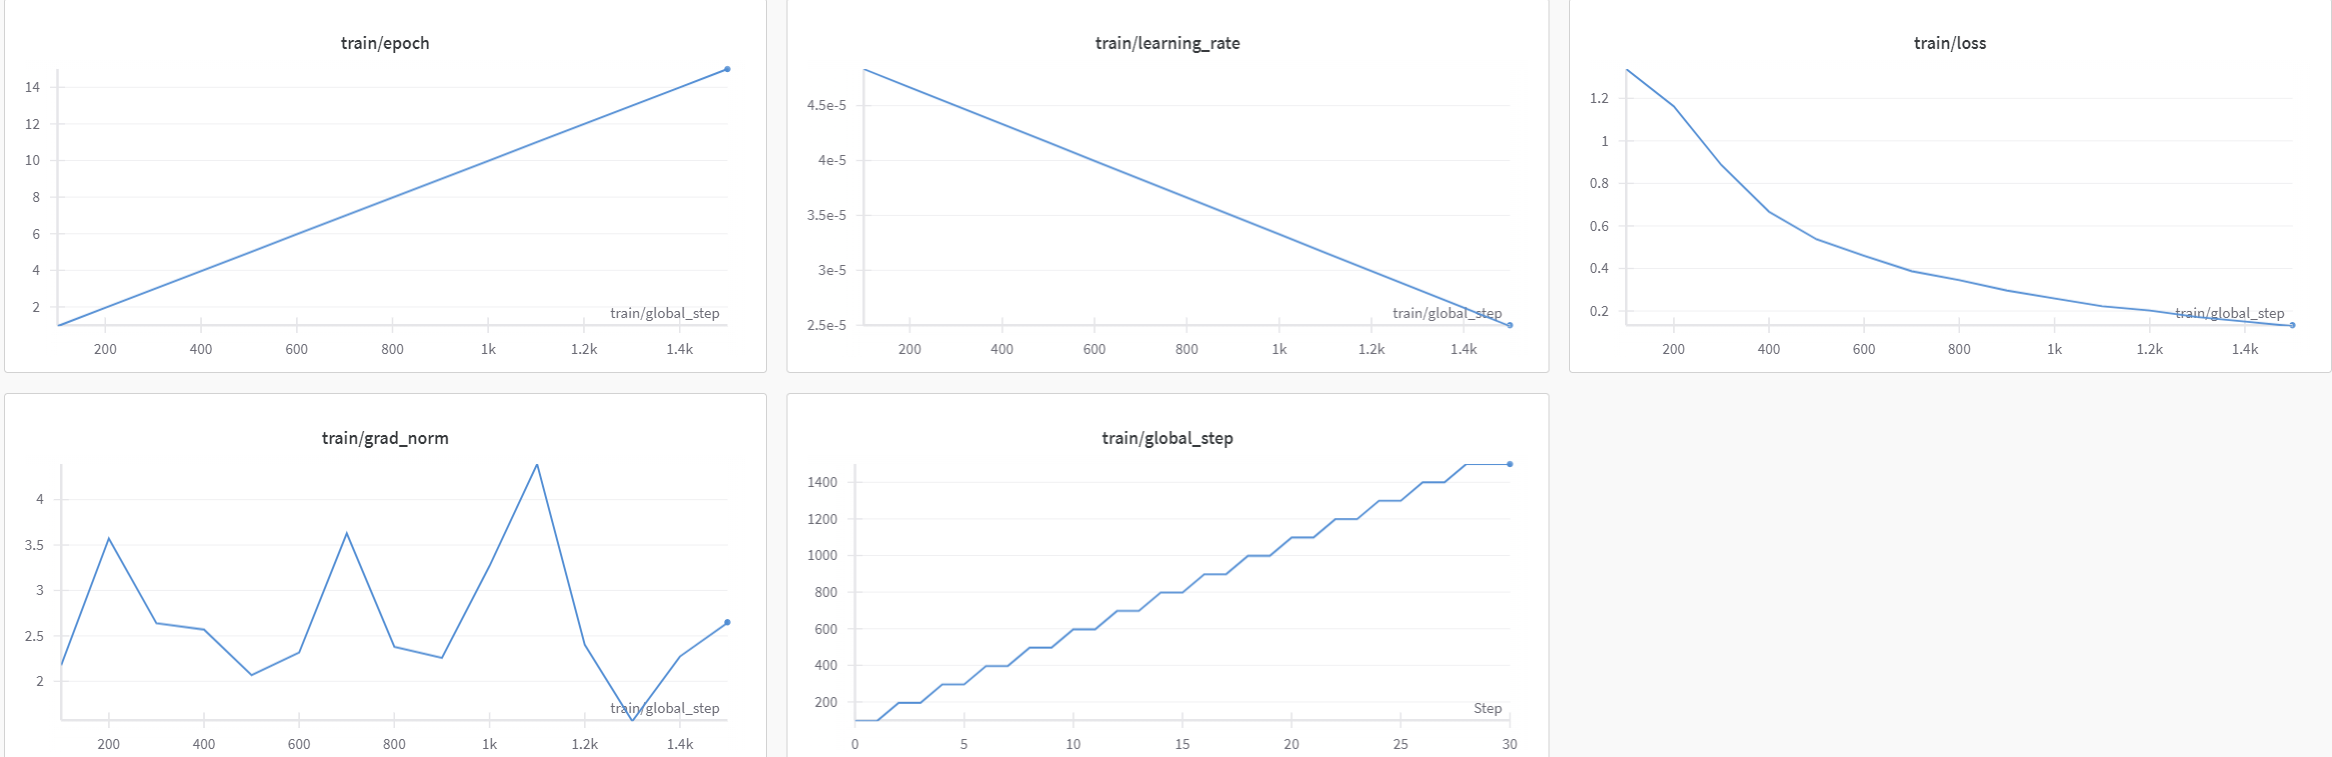

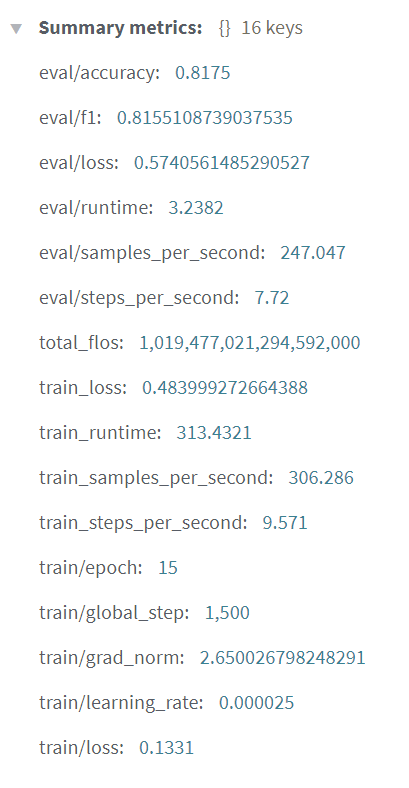